In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
#%matplotlib inline
import seaborn as sns; sns.set()
from sklearn.preprocessing import StandardScaler


In [2]:
train = pd.read_csv("bitcoin_price_Training - Training.csv")
test = pd.read_csv("bitcoin_price_1week_Test - Test.csv")

In [3]:
train = train[::-1]
test = test[::-1]


In [4]:
train.head()

,Date,Open,High,Low,Close,Volume,Market Cap
1555,"Apr 28, 2013",135.30,135.98,132.10,134.21,-,"1,500,520,000"
1554,"Apr 29, 2013",134.44,147.49,134.00,144.54,-,"1,491,160,000"
1553,"Apr 30, 2013",144.00,146.93,134.05,139.00,-,"1,597,780,000"
1552,"May 01, 2013",139.00,139.89,107.72,116.99,-,"1,542,820,000"
1551,"May 02, 2013",116.38,125.60,92.28,105.21,-,"1,292,190,000"


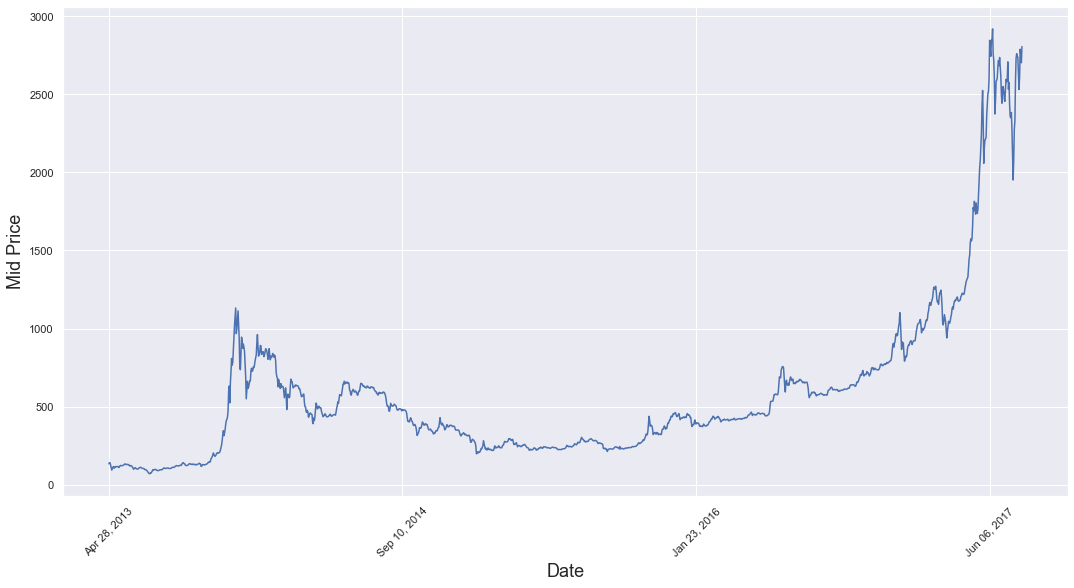

In [5]:

plt.figure(figsize = (18,9))
plt.plot(range(train.shape[0]),(train['Low']+train['High'])/2.0)
plt.xticks(range(0,train.shape[0],500),train['Date'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()

<AxesSubplot:>

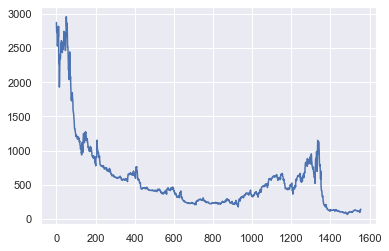

In [6]:
train['Close'].plot()

In [7]:
train = train['Close'].values.astype('float32')
test = test['Close'].values.astype('float32')


In [8]:
def generator(data, lookback, delay, min_index, max_index, 
              shuffle=False, batch_size=128, step=1):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
                
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay]
        yield samples, targets

In [9]:
# scalovanie udajov
train = train.reshape(-1, 1)
test = test.reshape(-1, 1)

scaler = StandardScaler()
train_n = scaler.fit_transform(train)
test_n = scaler.transform(test)

In [10]:
lookback = 24
step = 1
delay = 7
batch_size = 128
train_gen = generator(train_n, lookback=lookback, delay=delay,
    min_index=0, max_index=1000, shuffle=True, step=step,
batch_size=batch_size)
val_gen = generator(train_n, lookback=lookback, delay=delay,
    min_index=1001, max_index=None, step=step, batch_size=batch_size)
test_gen = generator(test_n, lookback=lookback, delay=delay,
    min_index=0, max_index=None, step=step, batch_size=batch_size)

val_steps = (len(train_n) - 1001 - lookback) // batch_size

test_steps = (len(test_n) - lookback) // batch_size

In [11]:

np.random.seed(5)

In [12]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

In [13]:
model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, train_n.shape[-1])))
model.add(layers.Dense(1,activation='tanh'))
model.compile(optimizer=RMSprop(), loss='mae')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 32)                3360      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 3,393
Trainable params: 3,393
Non-trainable params: 0
_________________________________________________________________


In [14]:
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=30,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/50


F:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


500/500 [==============================] - 12s 19ms/step - loss: 0.1313 - val_loss: 0.4968
Epoch 2/50
500/500 [==============================] - 7s 15ms/step - loss: 0.0972 - val_loss: 0.4864
Epoch 3/50
500/500 [==============================] - 8s 15ms/step - loss: 0.0893 - val_loss: 0.4904
Epoch 4/50
500/500 [==============================] - 7s 14ms/step - loss: 0.0851 - val_loss: 0.4740
Epoch 5/50
500/500 [==============================] - 7s 15ms/step - loss: 0.0830 - val_loss: 0.4971
Epoch 6/50
500/500 [==============================] - 9s 18ms/step - loss: 0.0808 - val_loss: 0.4765
Epoch 7/50
500/500 [==============================] - 8s 15ms/step - loss: 0.0799 - val_loss: 0.4764
Epoch 8/50
500/500 [==============================] - 7s 14ms/step - loss: 0.0786 - val_loss: 0.4807
Epoch 9/50
500/500 [==============================] - 7s 14ms/step - loss: 0.0740 - val_loss: 0.4955
Epoch 10/50
500/500 [==============================] - 8s 15ms/step - loss: 0.0705 - val_loss: 0.5026

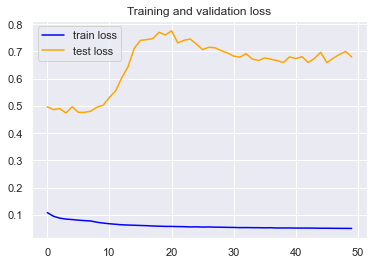

In [15]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
plt.figure()
plt.plot(epochs, loss, 'blue', label='train loss')
plt.plot(epochs, val_loss, 'orange', label='test loss')
plt.title('Training and validation loss')
plt.legend()

In [16]:
train_re = train_n.reshape(-1,1,1)
pred = model.predict(train_re)

In [17]:
pred = scaler.inverse_transform(pred)

Text(0.5, 1.0, 'Prediction on training data')

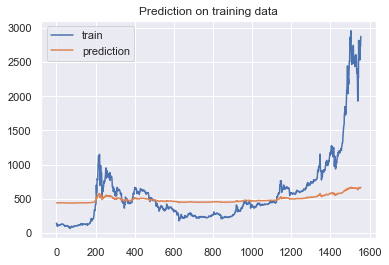

In [18]:
plt.plot(range(len(train_re)), train, label='train')
plt.plot(range(len(train_re)), pred, label='prediction')
plt.legend()
plt.title("Prediction on training data")